In [3]:
import time
import numpy as np
import cvxpy as cvx

In [4]:
import matplotlib
import matplotlib.pyplot as plt

In [5]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 4,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

Для начала перечислим некоторые классы функций, для которых мы будем строить наши методы оптимизации

Выпуклые функции
$$
f(x_{k+1}) \geq f(x_k) + \nabla f(x_k)^\top (x_{k+1} - x_k)
$$

Функции с $L$-Липшицевым градиентом
$$
f(x_{k+1}) \leq f(x_k) + \nabla f(x_k)^\top (x_{k+1} - x_k) + \frac{L}{2} \| x_{k+1} - x_k \|^2_2
$$

Сильно-выпуклые функции

$$
f(x_{k+1}) \geq f(x_k) + \nabla f(x_k)^\top (x_{k+1} - x_k) + \frac{\mu}{2} \| x_{k+1} - x_k \|^2_2
$$



# Iteration methods

Большинство методов итеративные и имеют вид:
$$x_k = x_{k-1}+\alpha_k h_k$$

В ML параметр $\alpha$ иногда так же называют "скорость обучения"

## 1.1. Start Point

1. Случайная инициализация

2. Оценить область, где может находиться $x$ и взять центр этой области

3. Решить упрощенную версию исходной задачи оптимизации $\min\limits_{x\in X} f(x)$, получить решение $\tilde{x}^*$ и взять $\text{proj}_X(\tilde{x}^*)$ как стартовую точку в исходной задаче.

## 1.2. Stop Rule

**Цель: Найти $x$ такой, что $f(x)-f^*\leq \varepsilon$**, где $f^*$ - это минимум

Критерии, которые гарантируют, что вы нашли $\varepsilon$-решение:

1. Duality Gap: $f(x_k) - g(\lambda, \nu)\leq \varepsilon$, где $g(\lambda, \nu) = \inf_x {L(x, \lambda, \nu)}$

2. Если есть нижняя оценка оптимального значения $f^* \geq p$, то $f(x_k)-p\leq \varepsilon$

3. Для некоторых алгоритмов бывают свои критерии. Например, метод Франк-Вульфа

Критерии без гарантии:

1. $|f_k - f_{k-1}| \leq \varepsilon$

2. $\|x_k - x_{k-1}\| \leq \varepsilon$

3. $\|\nabla f(x_k)\|\leq \varepsilon$

## 1.3. Step Size

1. Constant Step Size $\alpha_k=1/L$
2. Убывающая последоватльность: $\alpha_k = \alpha(k)$. Например, $\alpha_k=\frac{2}{k + 2}$.  
3. Наискорейший спуск: $\alpha_k = \arg\min_{\alpha \geq 0} f(x_k+\alpha_k h_k)$. Жадно отбираем наилучший шаг на каждой итерации.

Если $h_k$ это направление убывания, то можно воспользоваться следующими правилами ($0 < \beta_1 < \beta_2 < 1$).  

Достаточное убывание: $f(x_{k+1}) \leq f(x_k) + \beta_1 \alpha_k \langle f'(x_k), h_k \rangle$  
Существенное убывание: $f(x_{k+1}) \geq f(x_k) + \beta_2 \alpha_k \langle f'(x_k), h_k \rangle$  
Условие кривизны: $\langle f'(x_{k+1}), h_k \rangle \geq \beta_2 \langle f'(x_k), h_k \rangle$    

4. Правило Армихо: Достаточное убывание

5. Правило Вольфа: Достаточное убывание + Существенное убывание

6. Правило Гольдштейна: Достаточное убывание + условие кривизны

![Правило Армихо](armijo_step_size.JPG "Optional Title")
Рис. $g(\alpha) = f(x_k) + \beta_1 \alpha_k \langle f'(x_k), x_{k+1} - x_k \rangle$

7. Линейный поиск параметра $L$ на каждой итерации.

На практике значение $L$ редко бывает известно, поэтому если шаг алгоритма зависит от параметра гладкости $L$, то на каждой итерации алгоритма можно подбирать такое $L$, которое удовлетворяет неравенству:
$$
f(x_{k+1}) \leq f(x_k) + \alpha \langle \nabla f(x_k), x_{k+1} - x_k \rangle + \frac{L}{2} \| x_{k+1} - x_k \|^2
$$

И таким образом регулировать $\alpha_k(L_k) = \frac{1}{L_k}$

8. Шаг Поляка-Шора.

$$
\alpha_k = \frac{f(x_k)-f^*}{\gamma ||\nabla f(x_k)||_2^2}
$$

Как подобрать параметр $\gamma$? Это можно делать с помощью процедуры линейного поиска как делали в шаге 7.

In [6]:
class StepSize:
    def __call__(self, x, h, k, *args, **kwargs):
        pass

In [7]:
class ConstantStepSize(StepSize):
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha

In [8]:
class SeqStepSize(StepSize):
    def __init__(self, d=1, alpha0=1, alpha_function=None):
        if alpha_function is not None:
            self.alpha_function = alpha_function
        else:
            self.alpha_function = lambda k: alpha0/(k+1)**d
    
    def __call__(self, x, h, k, *args, **kwargs):
        return self.alpha_function(k)

In [9]:
class Armijo(StepSize):
    def __init__(self, beta=0.3, rho=0.1, alpha0=1):
        self.beta = beta
        self.rho = rho
        self.alpha0 = alpha0

    # h это направление спуска (антиградиент в случае градиентного спуска)
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        beta, rho, alpha = self.beta, self.rho, self.alpha0
        fx = f(x)
        hg = h.dot(gradf(x))
        while f(x + alpha * h) > fx + beta * alpha * hg:
            alpha *= rho
        return alpha

class Wolfe(StepSize):
    def __init__(self, beta1=0.3, beta2=0.9, rho1=0.1, rho2=2, alpha0=1):
        self.beta1, self.beta2 = beta1, beta2
        self.rho1, self.rho2 = rho1, rho2
        self.alpha0 = alpha0

    # h это направление спуска (антиградиент в случае градиентного спуска)
    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        beta1, rho1, alpha = self.beta1, self.rho1, self.alpha0
        beta2, rho2 = self.beta2, self.rho2
        lb, ub = 0, np.inf
        fx = f(x)
        g = gradf(x)
        hg = h.dot(g)
        while True:
            x_new = x + alpha * h
            if f(x_new) > fx + beta1 * alpha * hg:
                ub = alpha
                alpha = 1/2 * (lb + ub)
            elif gradf(x_new).dot(h) < beta2 * hg:
                lb = alpha
                if np.isinf(ub):
                    alpha = 2 * lb
                else:
                    alpha = 0.5 * (lb + ub)
            else:
                return alpha
            if ub - lb <= 1e-12:
                return alpha

In [10]:
class BacktrackingStepSize(StepSize):
    def __init__(self, L_init=1.0):
        self.L = L_init
    
    def __call__(self, x, h, k, gradf, f):
        L = self.L
        fx = f(x)
        gx = gradf(x)
        while True:
            alpha = 1.0 / L
            x_new = x + alpha * h
            fx_new = f(x_new)
            rhs = fx + alpha * np.dot(gx, h) + (L / 2.0) * np.linalg.norm(x_new - x) ** 2
            if fx_new <= rhs:
                self.L = L / 2.0   # decrease L for next call
                return alpha
            else:
                L *= 2.0

In [11]:
class PolyakBacktrackingStepSize(StepSize):
    def __init__(self, f_sol=0, const_div=1.0, min_div=1e-9, max_div=1e9):
        self.f_sol = f_sol
        self.const_div = const_div
        self.min_div = min_div
        self.max_div = max_div

    def __call__(self, x, h, k, gradf, f, *args, **kwargs):
        fx = f(x)
        gx = gradf(x)

        while True:
            denom = self.const_div * np.linalg.norm(gx) + 1e-12
            alpha = (fx - self.f_sol) / denom
            x_new = x + alpha * h
            fx_new = f(x_new)

            if fx_new < fx:  
                # success → allow slightly larger steps next time
                self.const_div = max(self.const_div / 2.0, self.min_div)
                return alpha
            else:
                # failure → shrink step
                self.const_div *= 2.0
                if self.const_div > self.max_div:
                    # safeguard: if too large, stop backtracking
                    return 0.0


## 1.4. Direction Choice

Простейший метод - **Gradient Descent**

$$x_k = x_{k-1}-\alpha_k \nabla f(x_k)$$

In [12]:
class GradientDescent:
    def __init__(self, StepSizeChoice, return_history=True, name=None):
        self.name = name
        self.StepSizeChoice = StepSizeChoice
        self.return_history = return_history
        self.history = []
    
    def __call__(self, x0, f, gradf, N):
        self.history = [(x0, time.time())]
        x = x0.copy()
        for k in range(N):
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x = x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
        return x
    
    def solve(self, x0, f, gradf, tol=1e-3, max_iter=10000):
        self.history = [(x0, time.time())]
        x = x0.copy()
        k = 0
        x_prev = None
        while x_prev is None or np.linalg.norm(gradf(x)) > tol: 
            h = -gradf(x)
            alpha = self.StepSizeChoice(x, h, k, gradf, f)
            x_prev, x = x, x + alpha * h
            if self.return_history:
                self.history.append((x, time.time()))
            if k >= max_iter:
                break
            k += 1
        return x

In [13]:
def parse_logs(xhistory, ret_time=False, funcx=None):
    values = [funcx(x) for x, _ in xhistory]
    if ret_time:
        times = [t for _, t in xhistory]
        times = [times[ind]-times[0] for ind, t in enumerate(times)]
    else:
        times = [i for i in range(len(xhistory))]
    return times, values

## 2. Gradient Descent

### 2.1. Quadratic programming

$$\min_{x \in \mathbb{R}^n} \frac{1}{2}x^\top A x + b^\top x$$

$$
\nabla f(x) = Ax + b
$$

In [14]:
np.random.seed(1)
n = 10
A = np.random.randn(n, n)
A = A.T @ A + 1e-1 * np.eye(n)
b = np.random.randn(n)
f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
gradf = lambda x: A @ x + b

In [15]:
x0 = np.zeros(n)
N = 1000

Найдём $L$ из неравенства Липшица-градиента $\| \nabla F(x) - \nabla F(y) \|_2 \leq L \|x - y \|_2$

In [16]:
L = max(np.linalg.eigvals(A))
L

np.float64(23.1355572287966)

In [17]:
methods = [
    GradientDescent(ConstantStepSize(1 / L), name="GD, 1/L"),
    GradientDescent(SeqStepSize(d=1), name="GD, 1/k"),
    GradientDescent(Armijo(rho=1/2, beta=0.3), name="GD, Armijo"),
    GradientDescent(Wolfe(), name="GD, Wolfe"),
    GradientDescent(BacktrackingStepSize(L_init=L), name="GD, Backtracking")
]

In [18]:
for method in methods:
    method.solve(x0, f, gradf, max_iter=N, tol=1e-12)
    print(f"{method.name}: {len(method.history)} iterations, f(x)={f(method.history[-1][0])}")

GD, 1/L: 1002 iterations, f(x)=-2.689510397630907
GD, 1/k: 1002 iterations, f(x)=-2.63346463769547
GD, Armijo: 1002 iterations, f(x)=-2.6895104105718035
GD, Wolfe: 1002 iterations, f(x)=-2.689510410571804
GD, Backtracking: 1002 iterations, f(x)=-2.68951041057176


Видим "всплеск" у убывающего шага связанный с тем, что первый шаг слишком длинный

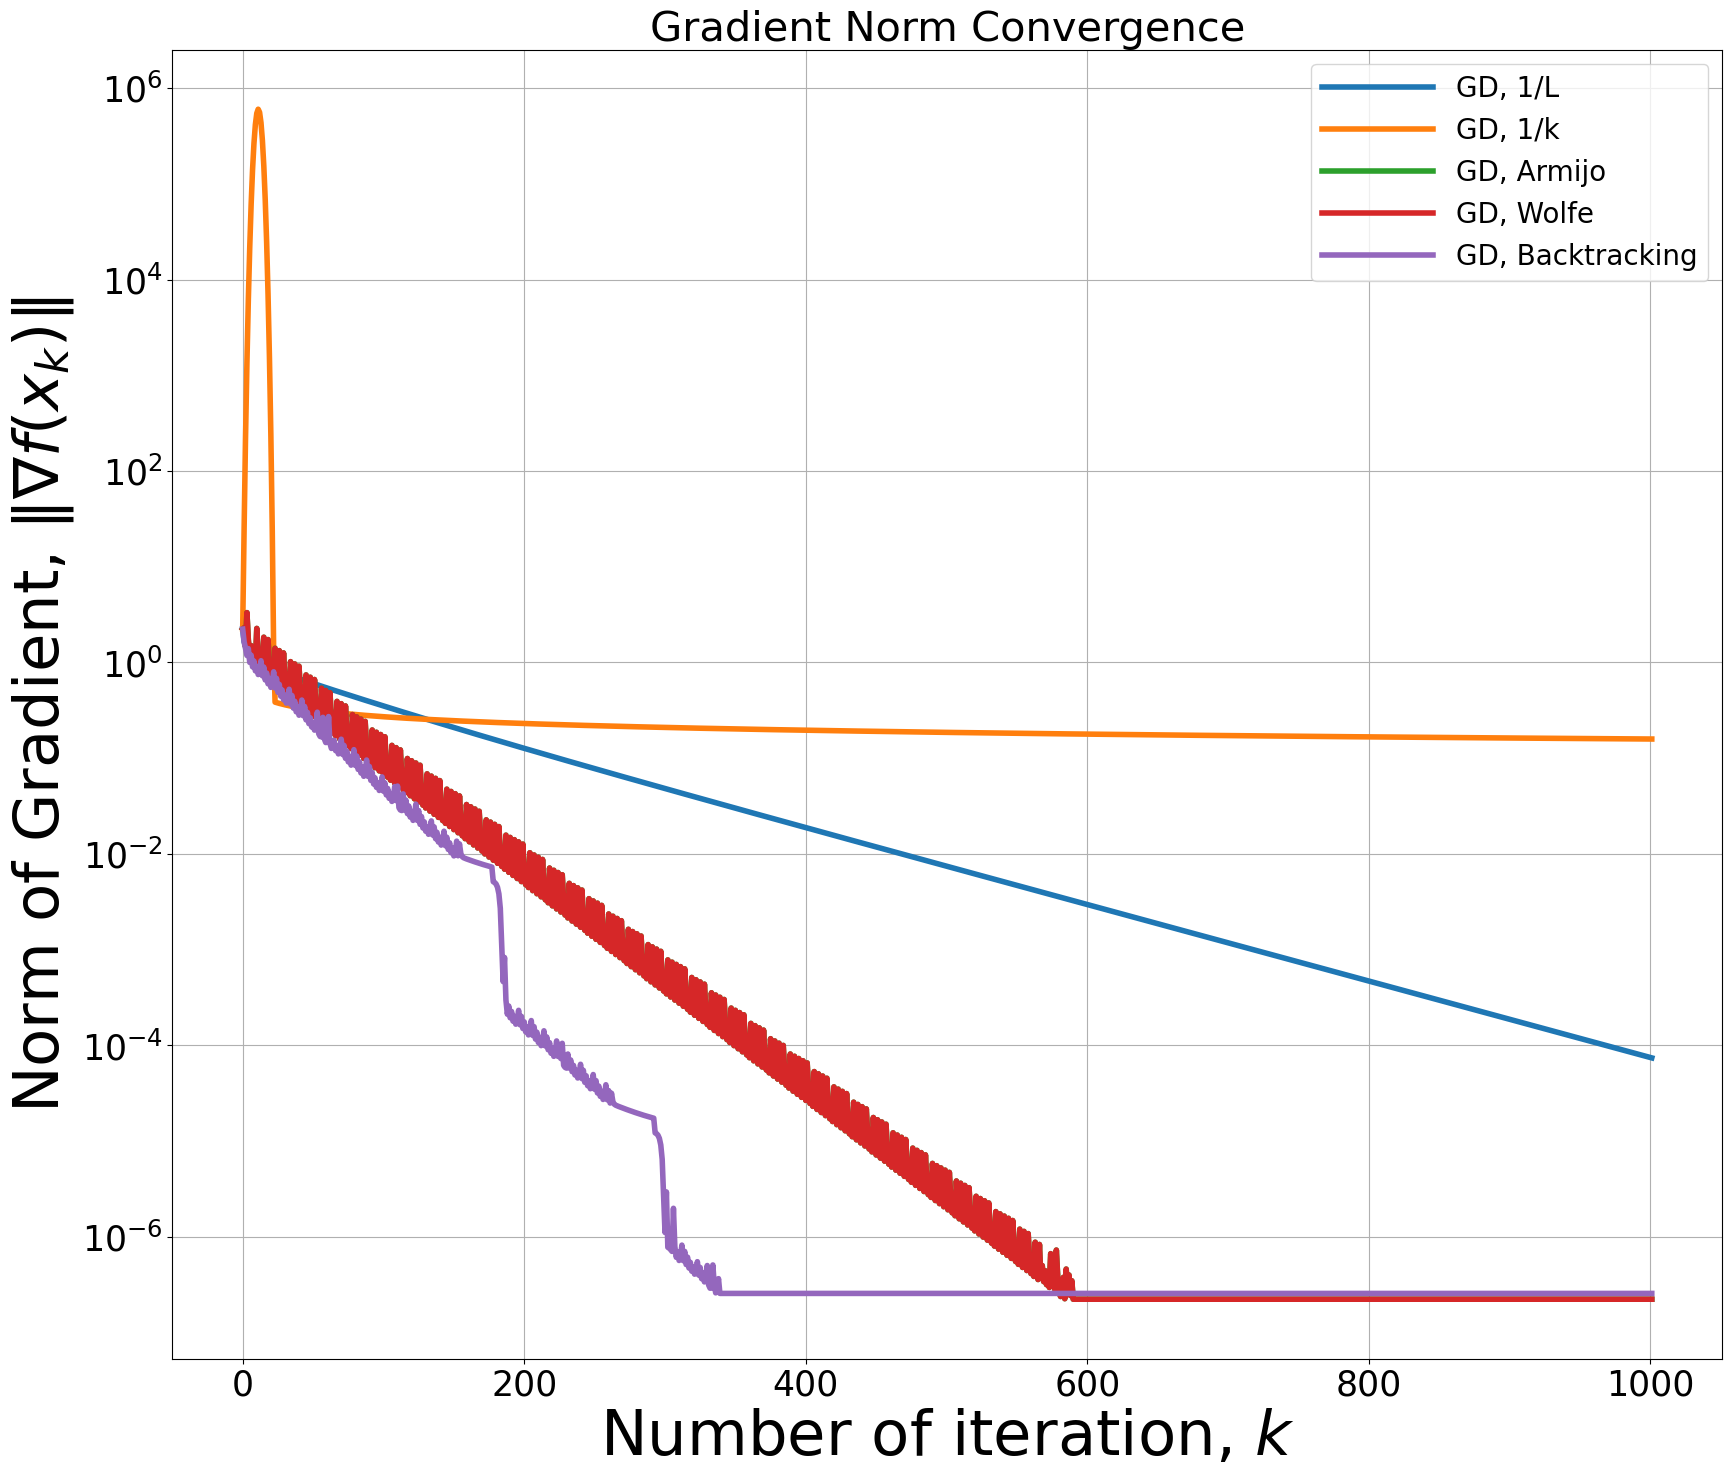

In [19]:
%matplotlib inline
plt.figure(figsize=(20, 17))
funcx = lambda x: np.linalg.norm(gradf(x))
plt.title("Gradient Norm Convergence")
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

In [20]:
all_values = []
funcx = lambda x: f(x) + 1e-9  # to avoid zero
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    all_values.append(values)

f_star = min([min(vals) for vals in all_values])

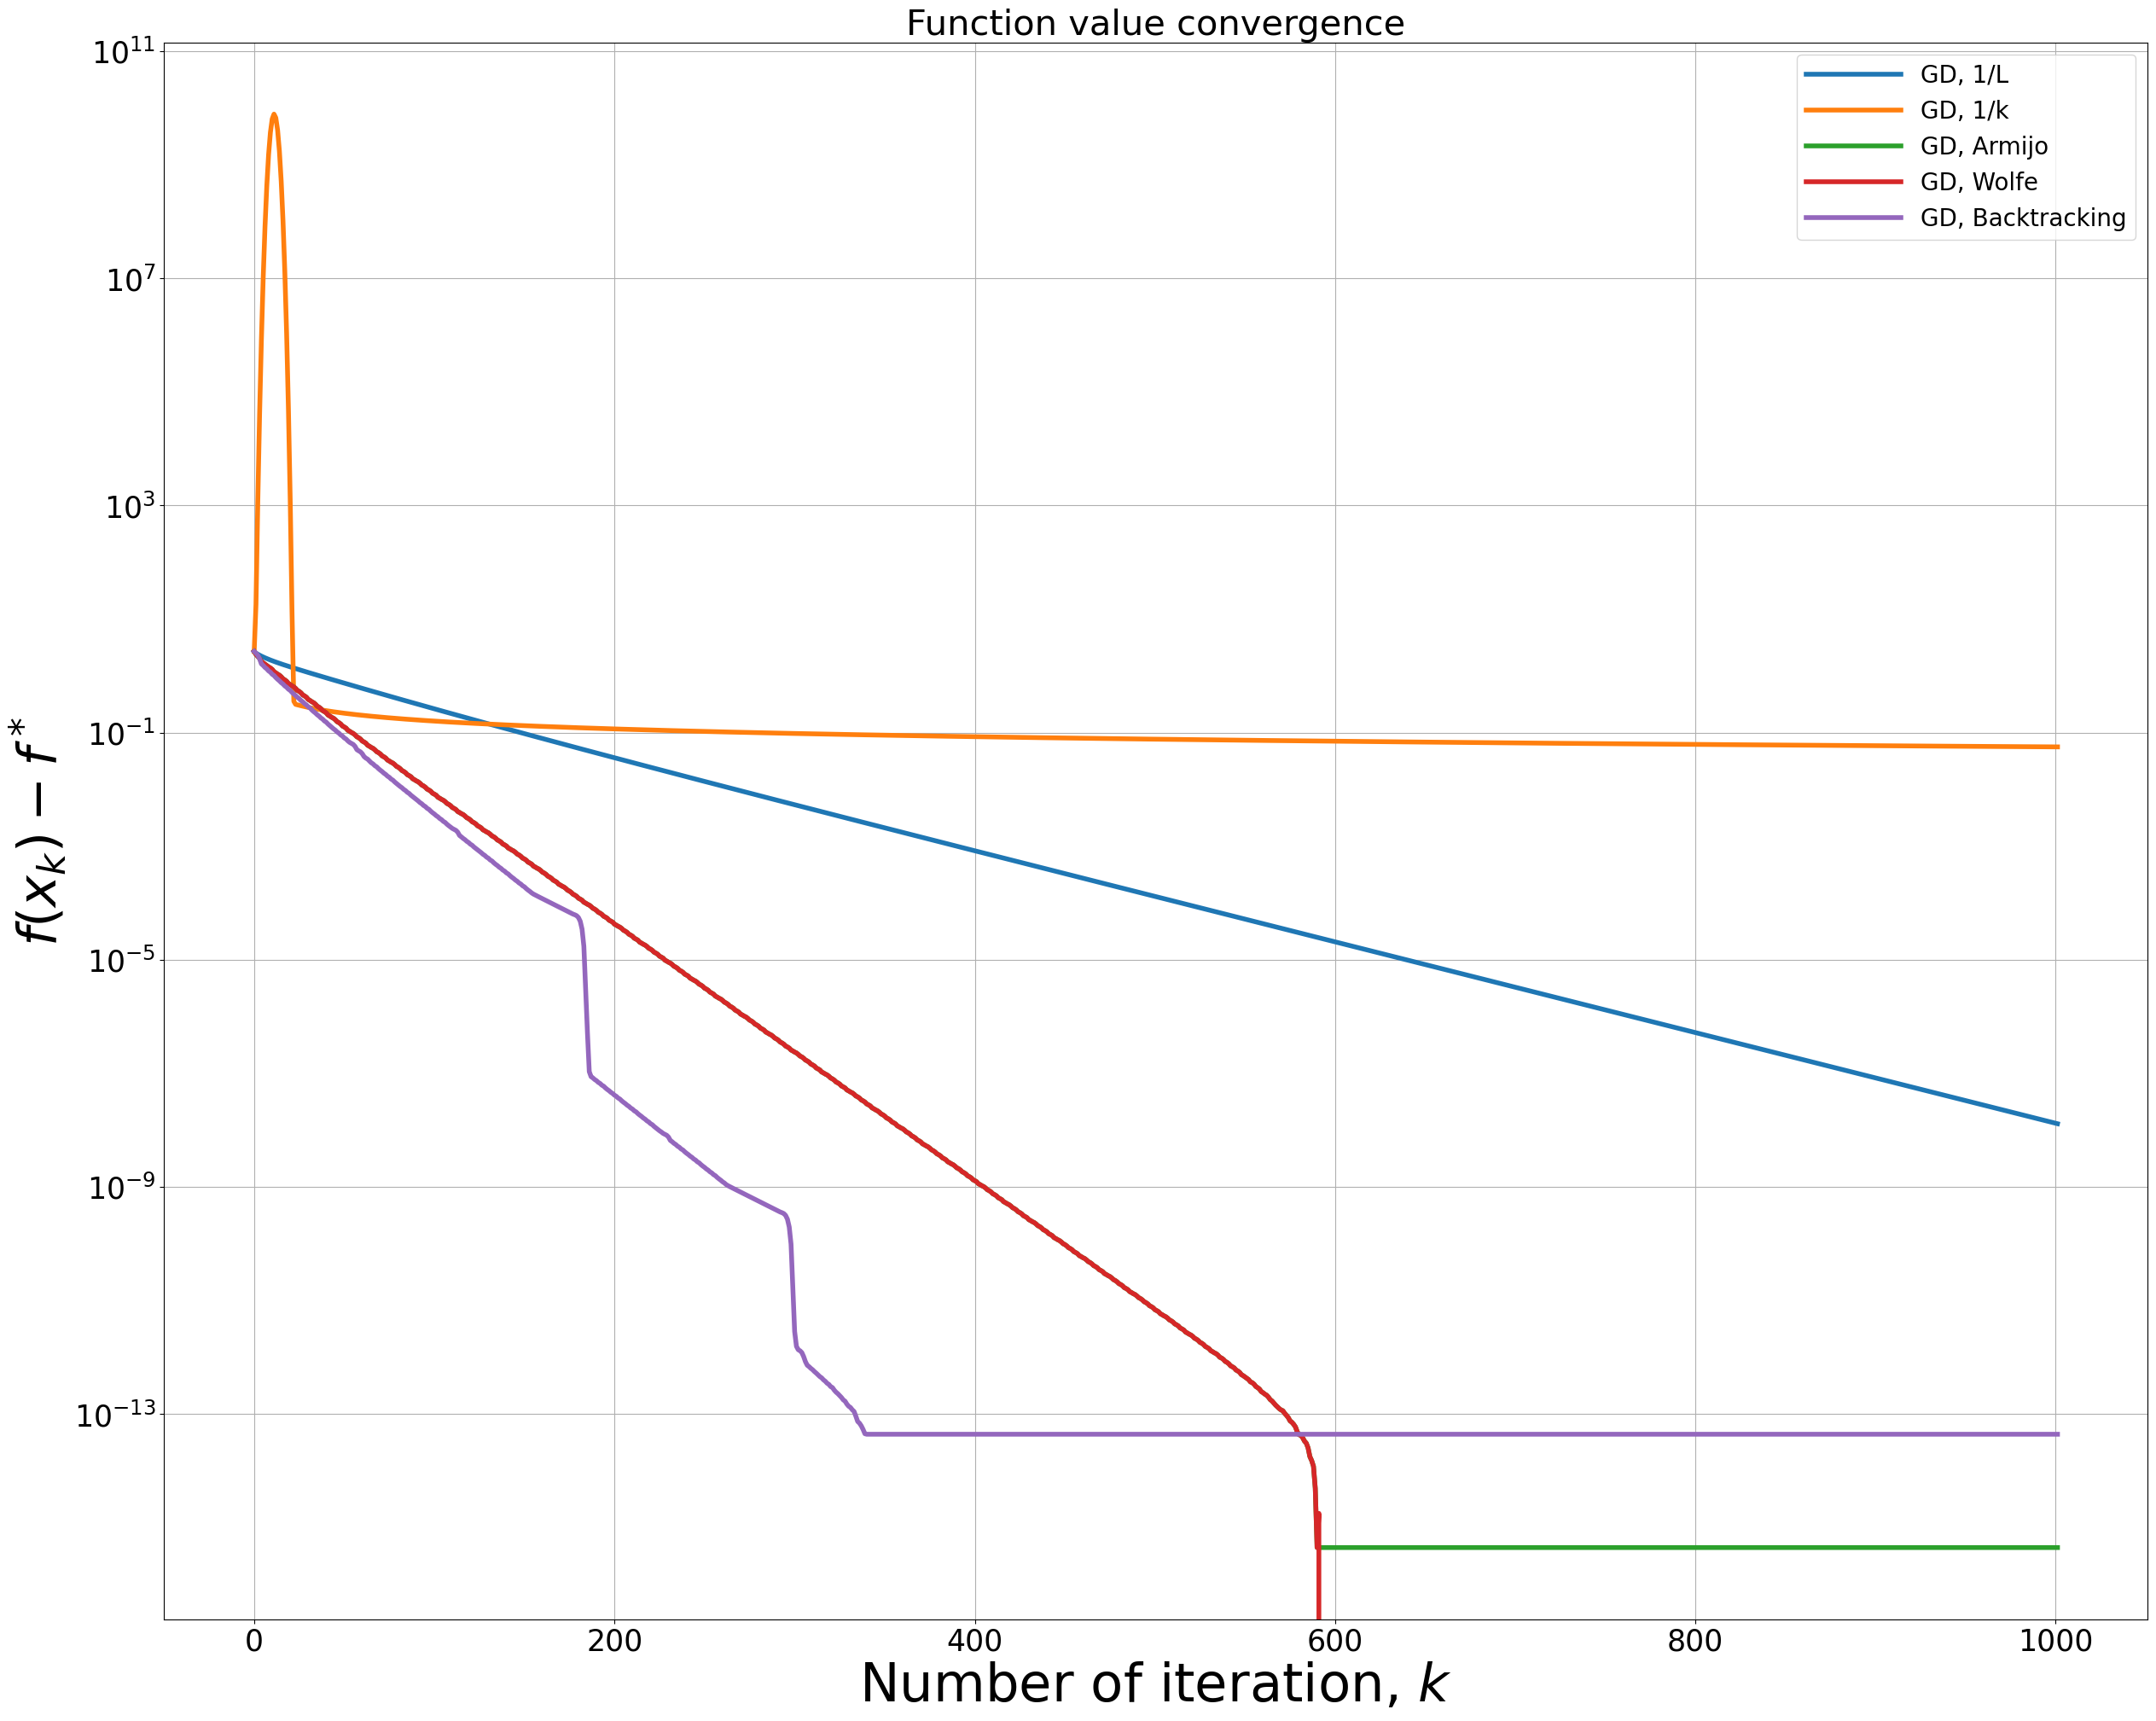

In [21]:
%matplotlib inline
plt.figure(figsize=(30, 24))
funcx = lambda x: f(x) 
plt.title("Function value convergence")
for method in methods:
    function_gaps = [val - f_star for val in all_values.pop(0)]
    plt.semilogy(times, function_gaps, label=method.name)
plt.grid()
plt.ylabel(r"$f(x_k) - f^*$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

In [22]:
methods = [
    GradientDescent(Wolfe(), name="GD, Wolfe"),
    GradientDescent(BacktrackingStepSize(L_init=L), name="GD, Backtracking"),
    GradientDescent(PolyakBacktrackingStepSize(f_sol=f_star, const_div=1.0), name="GD, Polyak")
]

In [23]:
for method in methods:
    method.solve(x0, f, gradf, max_iter=N, tol=1e-12)
    print(f"{method.name}: {len(method.history)} iterations, f(x)={f(method.history[-1][0])}")

GD, Wolfe: 1002 iterations, f(x)=-2.689510410571804
GD, Backtracking: 1002 iterations, f(x)=-2.68951041057176
GD, Polyak: 1002 iterations, f(x)=-2.6895104095777542


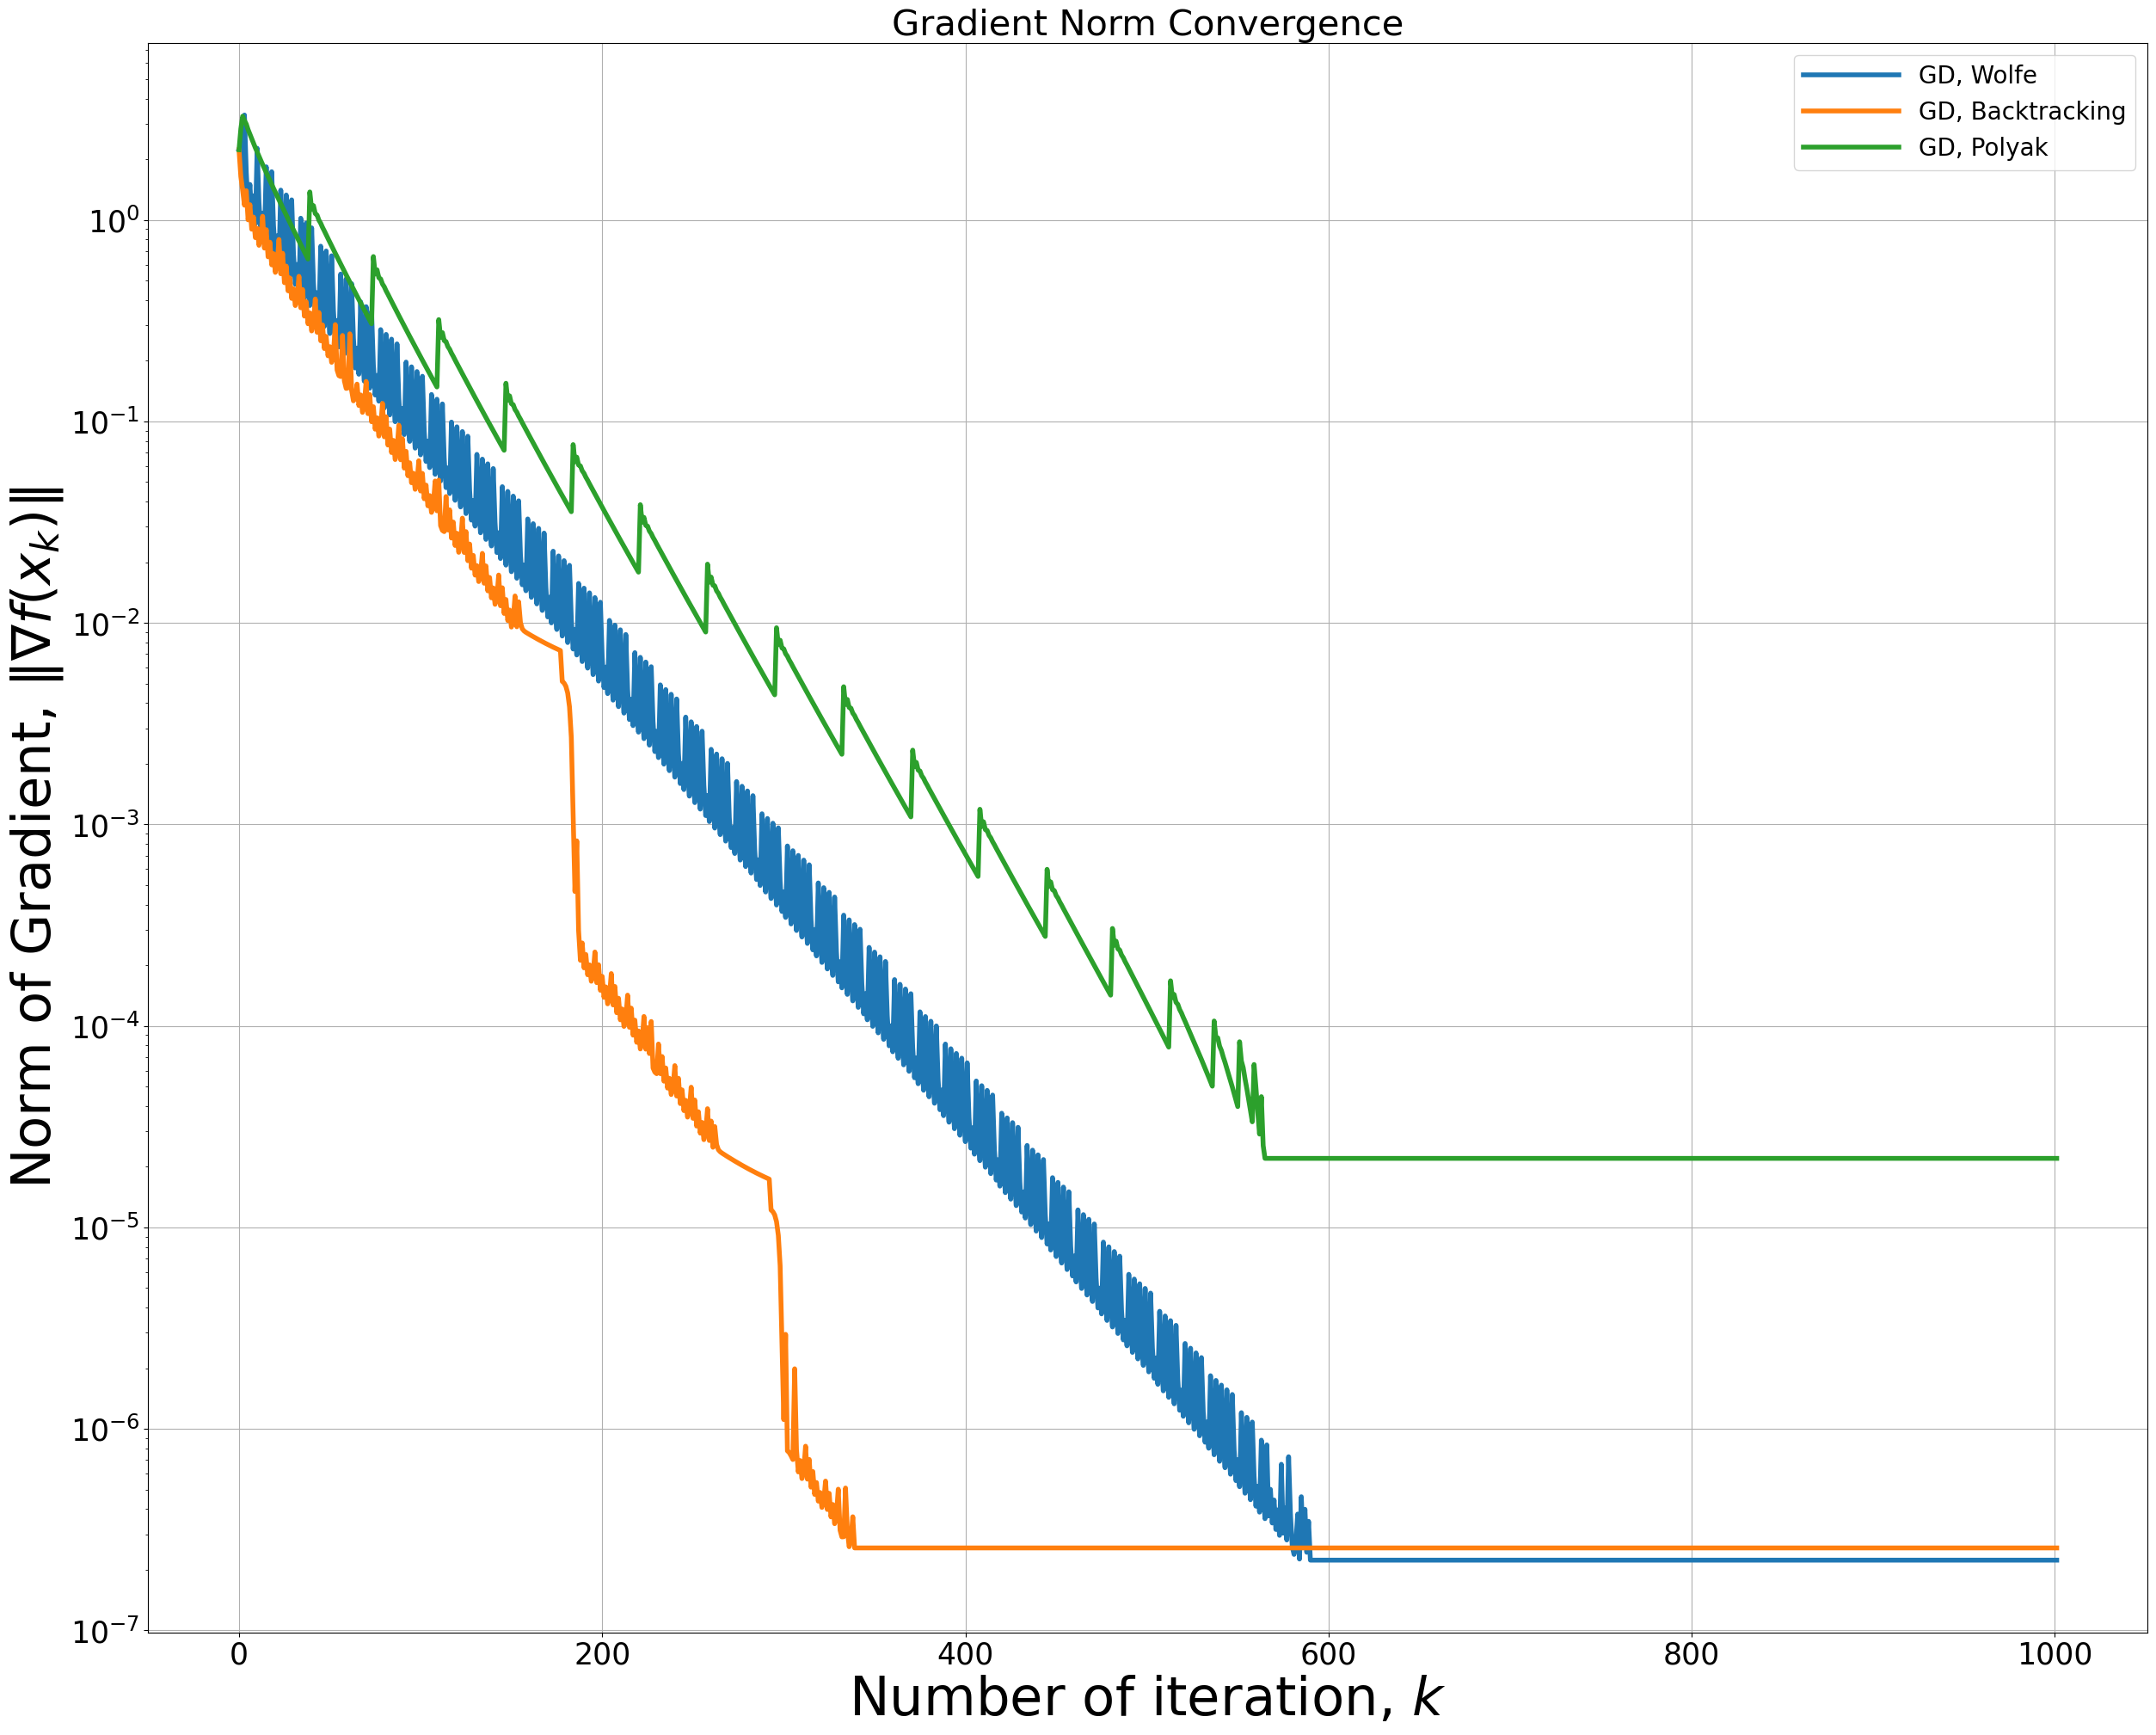

In [24]:
%matplotlib inline
plt.figure(figsize=(30, 24))
funcx = lambda x: np.linalg.norm(gradf(x))
plt.title("Gradient Norm Convergence")
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times, values, label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

#### n = 100

In [25]:
np.random.seed(1)
n = 100
A = np.random.randn(n, n)
A = A.T @ A
b = np.random.randn(n)
f = lambda x: 1/2 * x.T @ A @ x + b.T @ x
gradf = lambda x: A @ x + b

x0 = np.ones(n)*8
N = 1000
L = max(np.linalg.eigvals(A))

In [26]:
methods = [GradientDescent(ConstantStepSize(1 / (L)), name=r"GD, 1/L"),
           GradientDescent(Armijo(rho=0.3), name=r"GD, Armijo"),
           GradientDescent(Wolfe(alpha0=1), name=r"GD, Wolfe"),
           GradientDescent(BacktrackingStepSize(L_init=L), name=r"GD, Backtracking")
          ]

In [27]:
for method in methods:
    method.solve(x0, f, gradf, max_iter=N, tol=1e-12)
    print(f"{method.name}: {len(method.history)} iterations, f(x)={f(method.history[-1][0])}")

GD, 1/L: 1002 iterations, f(x)=-27.291993333368076
GD, Armijo: 1002 iterations, f(x)=-50.69242666894802
GD, Wolfe: 1002 iterations, f(x)=-41.950932900935754
GD, Backtracking: 1002 iterations, f(x)=-48.21241787478948


Замечаем, что градиент функции у адаптивных методов прыгает вверх вниз более скачкообразно.

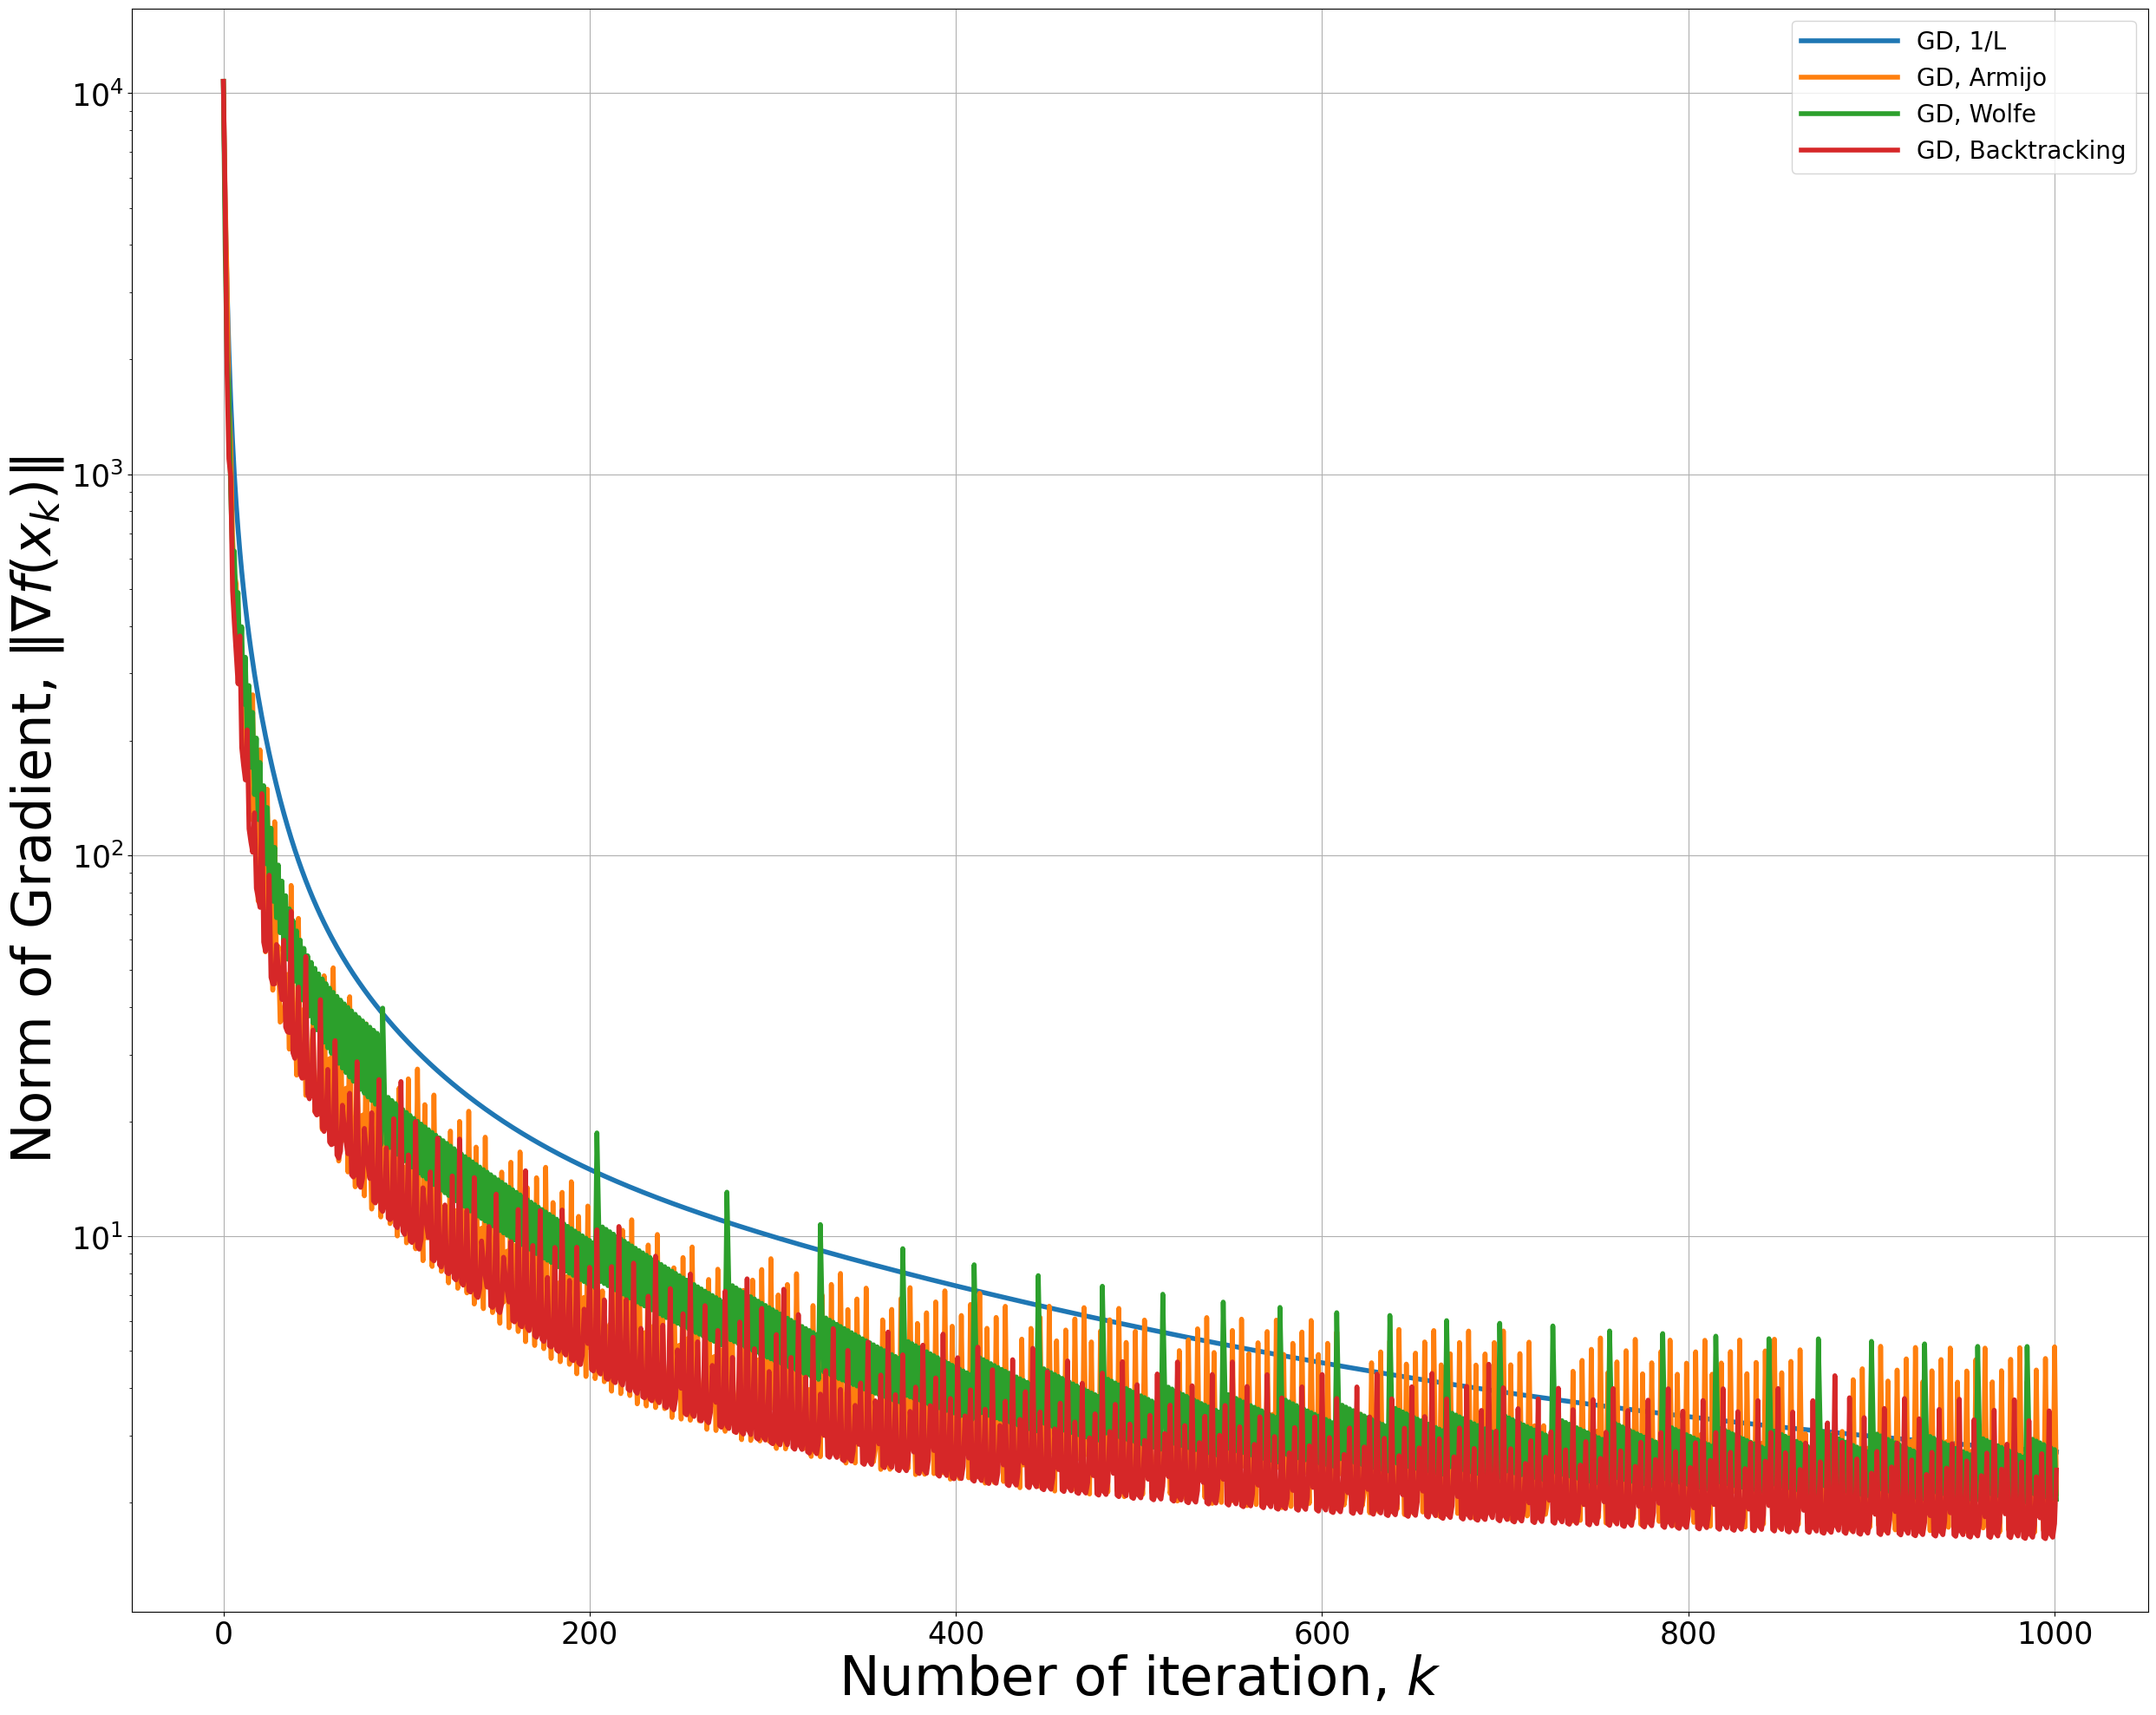

In [28]:
%matplotlib inline
plt.figure(figsize=(30, 24))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(times[::], values[::], label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $\|\nabla f(x_k)\|$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()

### 2.2. Число обусловленности (Conditional Number)

Число обусловленности расчитывается как отношение константы Липшица градиента функции к константе сильной выпуклости:

$$\mu I_n \prec \nabla^2 f(x) \prec L I_n$$

$$
\kappa = \frac{L}{\mu} = \frac{\lambda_\text{max} (\nabla^2 f(x))}{\lambda_\text{min} (\nabla^2 f(x))}
$$
, где $\lambda$ - собственное число матрицы $A$.

Для градиентного метода чем выше данное число, тем хуже его сходимость.

Какая связь между градиентным методом и числом обусловленности? Для ГМ существует оценка сходимости для постоянного шага $\alpha = \frac{2}{\mu + L}$

$$
f(x_k) - f^* \leqslant \frac{L}{2} \left( \frac{\kappa - 1}{\kappa + 1} \right)^{2k} \|x_0 - x^*\|^2, \\
$$

См. Теорему 2.1.15 Ю.Нестеров "Введение в выпуклую оптимизацию" (липшицевы, выпуклые и сильно выпуклые функции).

#### Квадратичная функция

Начнем рассмотрение числа обусловленности с квадратичной функции.

$$\min_{x \in \mathbb{R}^n} \frac{1}{2}x^\top A x$$

$$\kappa=\frac{\lambda_{\max}(A)}{\lambda_{\min}(A)} > 1$$

In [29]:
n = 2
x0 = np.zeros(n) + 1

In [30]:
gammas = []
iters = []
histories = []

for i in range(0, 5):
    gamma = 10**i
    A = np.diag([gamma, 1])
    gammas.append(gamma)
    L = max(1, gamma)
    method = GradientDescent(ConstantStepSize(1 / L), name="GD")
    f = lambda x: 1/2 * x.T @ A @ x
    gradf = lambda x: A @ x
    method.solve(x0, f, gradf, tol=1e-9)
    # iters.append(len(method.history))

    # Extract only the x values from the history (ignore timestamps)
    points = np.array([entry[0] for entry in method.history])
    histories.append(points)
    iters.append(len(points))

Фиксируем увеличение числа итераций при увеличении числа обусловленности

<>:7: SyntaxWarning: invalid escape sequence '\k'
<>:7: SyntaxWarning: invalid escape sequence '\k'
C:\Users\alexa\AppData\Local\Temp\ipykernel_9536\4122401579.py:7: SyntaxWarning: invalid escape sequence '\k'
  plt.xlabel("$\kappa$")


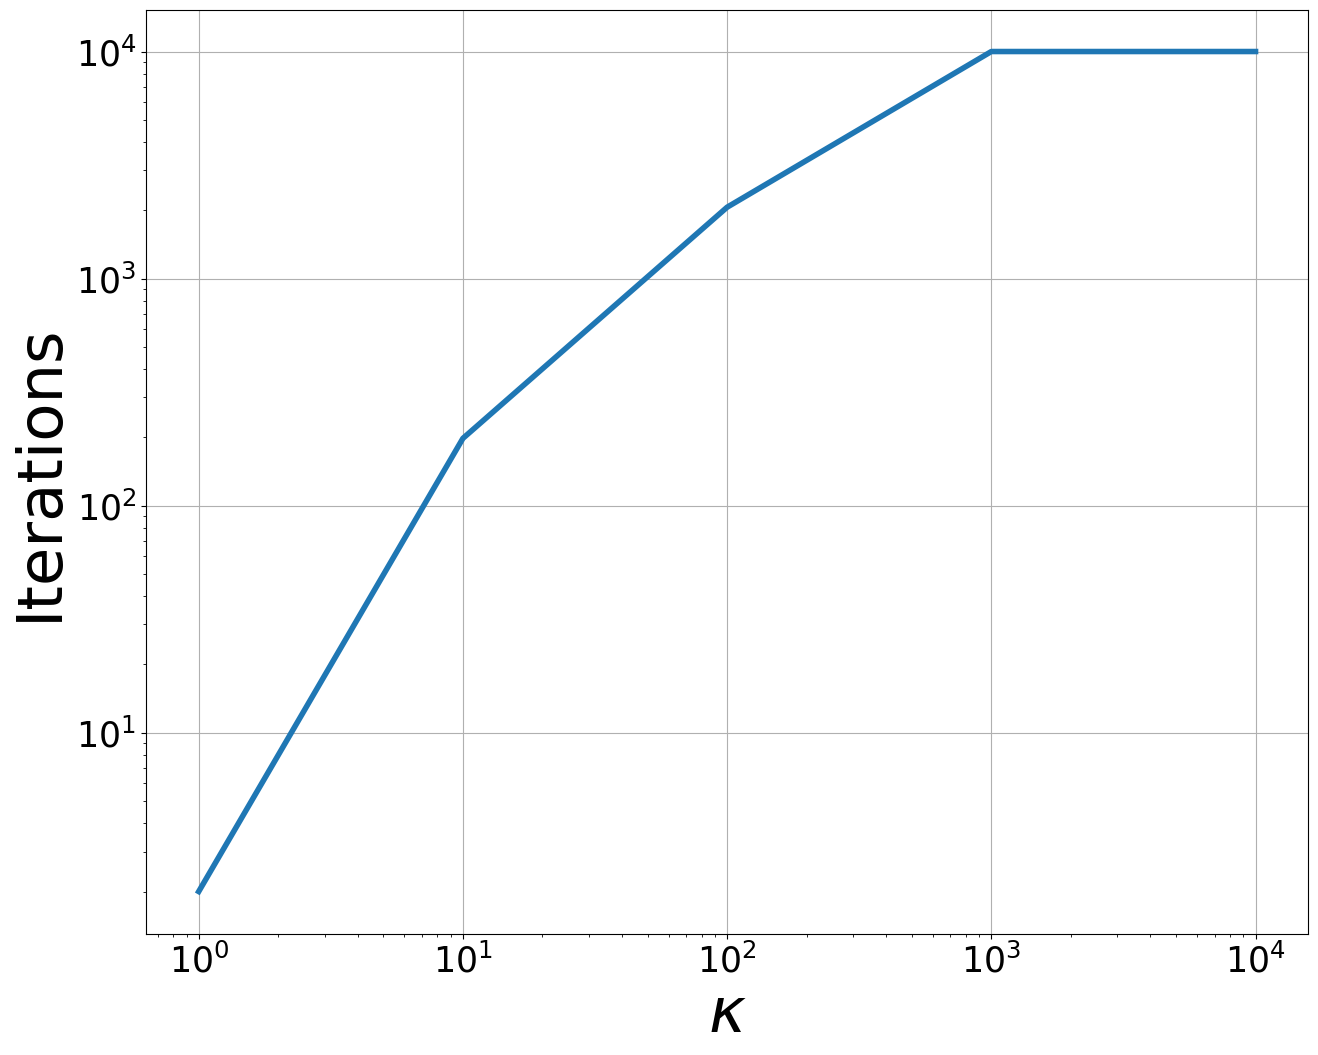

In [31]:
%matplotlib inline
plt.figure(figsize=(15,12))
plt.plot(gammas, iters)
plt.xscale("log")
plt.yscale("log")
# plt.xlabel("Conditional Number")
plt.xlabel("$\kappa$")
plt.ylabel("Iterations")
plt.grid()

#### Геометрический смысл числа обусловленности

<>:20: SyntaxWarning: invalid escape sequence '\k'
<>:20: SyntaxWarning: invalid escape sequence '\k'
C:\Users\alexa\AppData\Local\Temp\ipykernel_9536\3510029553.py:20: SyntaxWarning: invalid escape sequence '\k'
  ax.set_title(f'$\kappa$ = {gamma:.0e}')


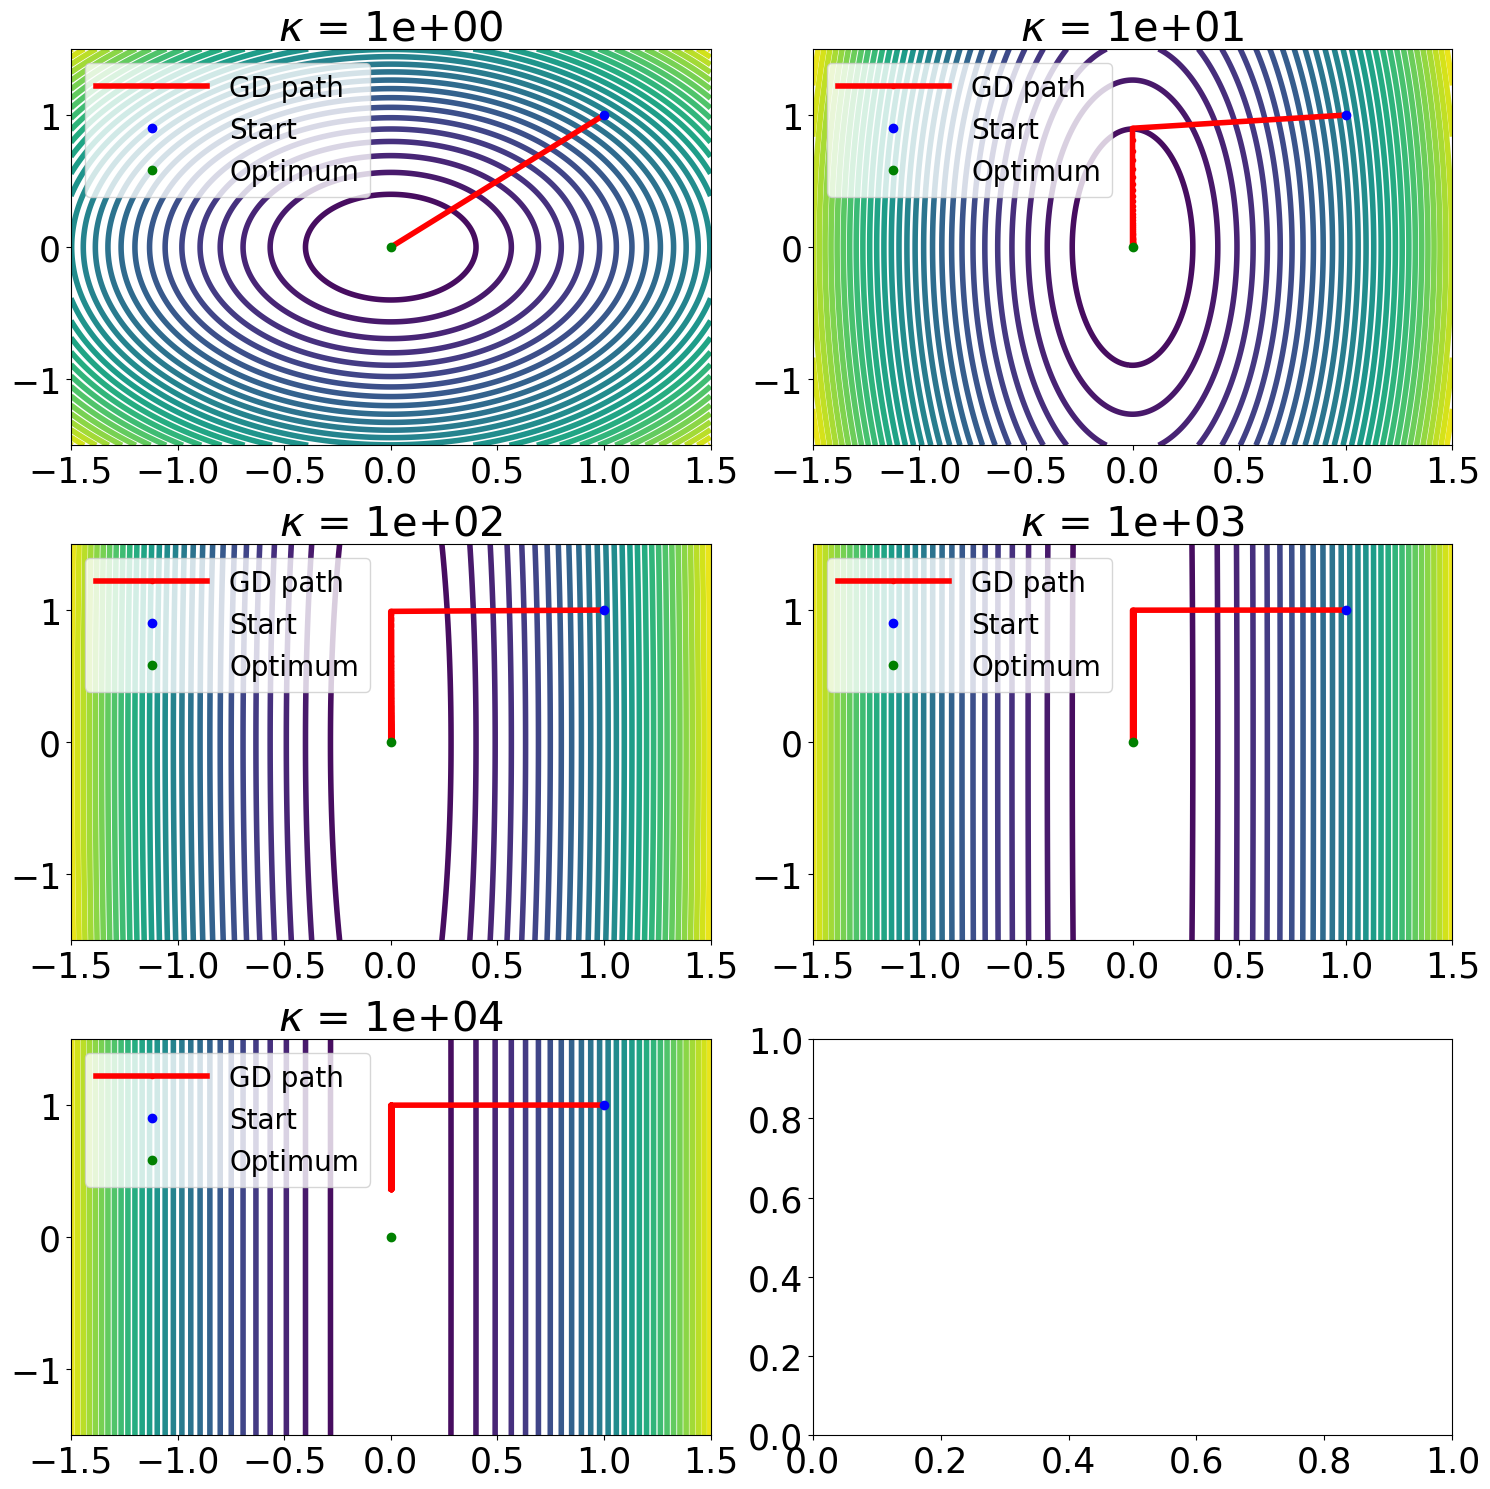

In [32]:
# Plot setup
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

# Define grid
x1 = np.linspace(-1.5, 1.5, 400)
x2 = np.linspace(-1.5, 1.5, 400)
X1, X2 = np.meshgrid(x1, x2)

# Plot contours and trajectories
for idx, (gamma, history) in enumerate(zip(gammas, histories)):
    A = np.diag([gamma, 1])
    Z = 0.5 * (A[0, 0] * X1**2 + A[1, 1] * X2**2)
    
    ax = axes[idx]
    ax.contour(X1, X2, Z, levels=30, cmap='viridis')
    ax.plot(history[:, 0], history[:, 1], 'r.-', label='GD path')
    ax.plot(x0[0], x0[1], 'bo', label='Start')
    ax.plot(0, 0, 'go', label='Optimum')
    ax.set_title(f'$\kappa$ = {gamma:.0e}')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.legend()

plt.tight_layout()
plt.show()

#### Пример расчета числа обусловленности эллипсоида

Пример числа обусловленности эллипсоида (см. Boyd, Stephen P., and Lieven Vandenberghe. Convex optimization. Cambridge university press, 2004.)

Итак формула эллипсоида:
$$
E = \{ x \ | \ (x - x_0)^\top A^{-1} (x - x_0) \leq 1 \}
$$

Мы проговорили, что число обусловленности функции - это ее "ширина", т.е. разница вида:

$$
\kappa = \sup_{z \in Q} {z^\top s} - \inf_{z \in Q} {z^\top s} \quad \quad (1)
$$
, где $\| s \|_2 = 1$.

По формуле (1) найдем $\kappa$ для эллипсоида. Для этого сделаем замену переменной $x$ на переменную $u$ таким образом, возьмем точку из эллипсоида: $z = x_0 + A^{1/2}u$, и покажем, что если брать точку в эллипсоиде таким образом, то можно опустить ограничение эллипсоида до неравенства $\| u \|_2 \leq 1$:

$$
(x_0 + A^{1/2}u - x_0)^\top A^{-1} (x_0 + A^{1/2}u - x_0) = (A^{1/2}u)^\top A^{-1} (A^{1/2}u) = u^\top A^{1/2} A^{-1} A^{1/2} u = 
$$
$$
u^\top A^{1/2} (A^{1/2} A^{1/2})^{-1} A^{1/2} u = u^\top A^{1/2} A^{-1/2} A^{-1/2} A^{1/2} u = u^\top u = \| u \|_2 \leq 1
$$

Теперь подставим данную точку эллипсоида в формулу (1), для этого найдем по отдельности $\sup$ и $\inf$:
$$
\sup_{\| u \| \leq 1} q^\top (x_0 + A^{1/2} u) = q^\top x_0 + \sup_{\| u \| \leq 1} q^\top (A^{1/2} u) = q^\top x_0 + \| A^{1/2} q \|
$$
, где мы воспользовались фактом, что $\sup_{\| u \| \leq 1} v^\top u = \| v \|_2$

и аналогично для $\inf$:
$$
\inf_{\| u \| \leq 1} q^\top (x_0 + A^{1/2} u) = q^\top x_0 - \sup_{\| u \| \leq 1} q^\top (A^{1/2} u) = q^\top x_0 - \| A^{1/2} q \|
$$

Тогда 
$$
\kappa = 2 \| A^{1/2} q \|_2
$$

А это прямо из определения спектральной нормы https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D1%8B есть $\sqrt{\lambda_{\max} (A)}$, а число обусловленности у нас выводится в квадрате, поэтому в итоге число обусловленности эллипсоида:

$$
\kappa = \frac{\lambda_{\max} (A)}{\lambda_{\min} (A)}
$$
Т.е. число обусловленности эллипсоида зависит от его матрицы.

#### Логистическая функция потерь с L2-регуляризацией

Рассмотрим более сложный пример, а именно задачу логистической регрессии с метками $y_i \in \{\pm 1\}$, признаковыми векторами $a_i \in \mathbb{R}^d$ и параметрами $x \in \mathbb{R}^d$.  

Функция потерь с L2-регуляризацией имеет вид:
$$
F(x) = -\frac{1}{n}\sum_{i=1}^n
\log\bigl(1+\exp(-y_i a_i^\top x)\bigr)
+\frac{\lambda}{2}\|x\|_2^2,
$$
где $\lambda>0$ — коэффициент регуляризации.


**Гессиан**
$$
\nabla^2 F(x) =
\frac{1}{n}\sum_{i=1}^n \sigma_i(1-\sigma_i) a_i a_i^\top
+ \lambda I_d.
$$

**Константа Липшица градиента**

$$
L = \frac{1}{4n}\lambda_{\max}(A^\top A) + \lambda,
$$
где $\lambda_{\max}(A^\top A)$ — наибольшее собственное значение матрицы $A^\top A$.

**Константа сильной выпуклости**

Гессиан $\nabla^2 F(x)$ удовлетворяет неравенству
$$
\nabla^2 F(x) \succeq \lambda I_d,
$$

**Число обусловленности**

Число обусловленности функции $F$ (в смысле отношения константы Липшица к константе сильной выпуклости):
$$
\kappa = \frac{\dfrac{1}{4n}\lambda_{\max}(A^\top A)+\lambda}{\lambda}.
$$

Судя по приведенной выше формуле:
- Чем сильнее регуляризация (большее $\lambda$), тем лучше обусловлена задача — число обусловленности становится ближе к 1.
- Чем слабее регуляризация (меньшее $\lambda$), тем хуже обусловленность — $\kappa$ может быть очень большим.

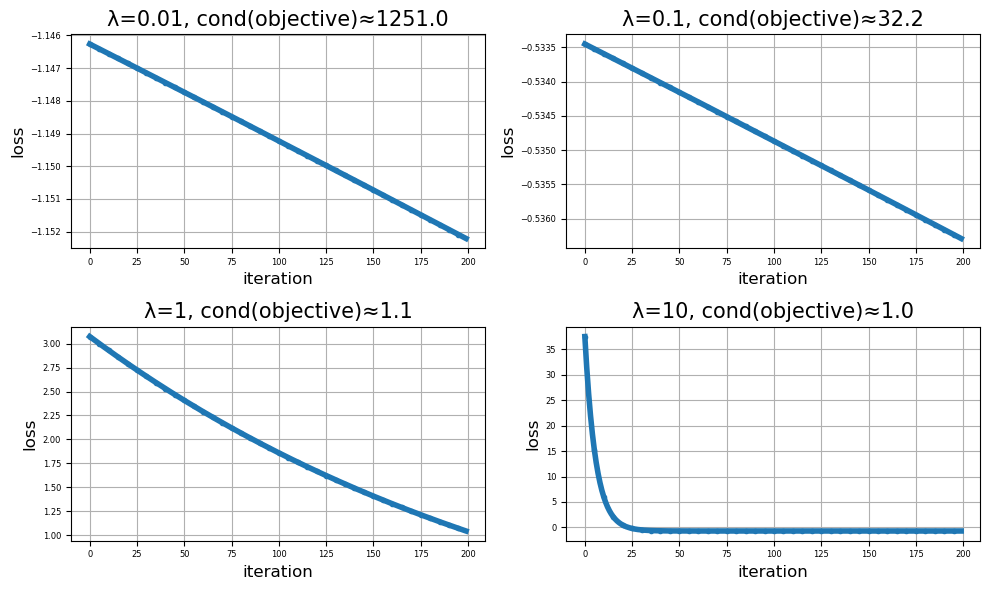

In [33]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(42)

params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 12,
          "xtick.labelsize": 6,
          "ytick.labelsize": 6,
          "lines.linewidth": 4,
           "axes.titlesize":15}
matplotlib.rcParams.update(params)

@jax.jit
def logistic_loss(x: np.ndarray, A: np.ndarray, y: np.ndarray, reg_pen: float) -> float:
    """Logistic loss + L2 regularization."""
    z = y * (A @ x)
    return -jnp.mean(jnp.logaddexp(0, -z)) + reg_pen * jnp.linalg.norm(x)**2

logistic_loss_gradf = jax.jit(jax.grad(logistic_loss, argnums=0))

def make_A_with_spectrum(n, m, s_vals, key):
    """Return an (n × m) matrix with prescribed singular values s_vals."""
    U, _ = jnp.linalg.qr(random.normal(key, (n, m)))
    V, _ = jnp.linalg.qr(random.normal(key, (m, m)))
    S = jnp.diag(s_vals)
    return U @ S @ V.T

def gradient_descent(f, grad_f, x0, lr, max_iter=200, tol=1e-8):
    x = x0
    history = []
    for k in range(max_iter):
        val = f(x)
        history.append(val)
        g = grad_f(x)
        if jnp.linalg.norm(g) < tol:
            break
        x = x - lr * g
    return jnp.array(history)

# Problem sizes
n_samples = 100
m_feature = 5

spectra = [
    jnp.geomspace(100.0, 1.0, m_feature),
    jnp.geomspace(50.0, 1.0, m_feature),
    jnp.geomspace(10.0, 1.0, m_feature),
    jnp.geomspace(2.0, 1.0, m_feature),
]
lambdas = [0.01, 0.1, 1, 10]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.ravel()

for ax, (lamda_pen, s) in zip(axes, zip(lambdas, spectra)):
    A_i = make_A_with_spectrum(n_samples, m_feature, s, key)
    y_i = random.choice(key, jnp.array([-1, 1]), shape=(n_samples,))
    f_i = lambda x: logistic_loss(x, A_i, y_i, lamda_pen)
    grad_i = lambda x: logistic_loss_gradf(x, A_i, y_i, lamda_pen)

    x0 = random.normal(key, (m_feature,))

    max_sing = jnp.linalg.svd(A_i, compute_uv=False)[0]
    lr = 0.1 / (max_sing**2 + 2 * lamda_pen)

    history = gradient_descent(f_i, grad_i, x0, lr)

    # ---- condition number of the objective ----
    L = (max_sing**2) / (4 * n_samples) + 2 * lamda_pen
    mu = 2 * lamda_pen
    cond_obj = L / mu

    ax.plot(history, marker='.', markevery=5,)
    ax.set_title(f"λ={lamda_pen}, cond(objective)≈{cond_obj:.1f}")
    ax.set_xlabel("iteration")
    ax.set_ylabel("loss")
    ax.grid(True)

plt.tight_layout()
plt.show()